In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1. Import các thư viện cần thiết**

In [ ]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


**2. Đọc file dữ liệu HPG và chia dataset theo tỉ lệ 8:1:1**

In [ ]:
# Đọc file dữ liệu
df = pd.read_csv('/content/drive/MyDrive/StockData/HPG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

**Xem** **lại** **dataset**

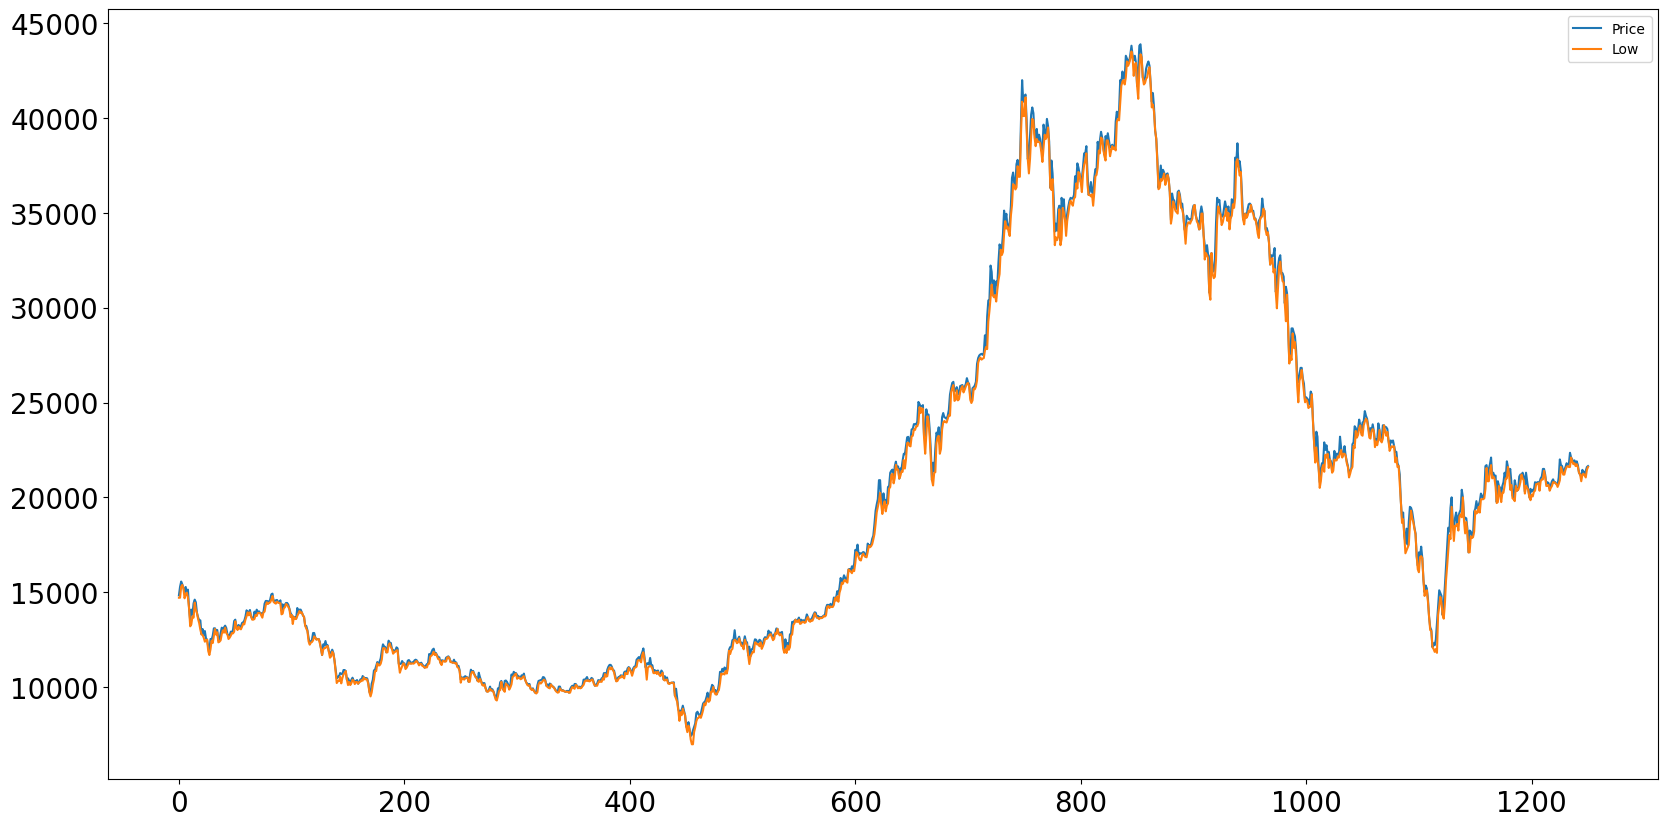

In [ ]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [ ]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2187642601016335,
 0.6654721662261358,
 15,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18731.487268410645)

In [ ]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [ ]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-7.395504537849762,
 7.797592879227417e-11,
 14,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 18715.811266993263)

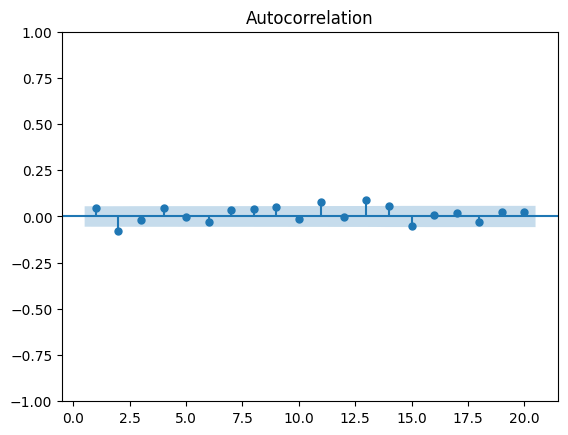

In [ ]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df

,Price,Low
0,14831.7,14706.0
1,15284.1,14706.0
2,15560.7,15284.1
3,15409.8,15384.7
4,15233.9,15208.7
...,...,...
1246,21350.0,21250.0
1247,21200.0,21150.0
1248,21400.0,21050.0
1249,21600.0,21450.0


In [ ]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=15213.103, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=15215.054, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=15214.712, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=15211.543, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=15215.062, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=15215.058, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=15216.946, Time=1.32 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=15213.104, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=15212.771, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=15210.454, Time=2.01 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=15212.279, Time=2.32 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=15212.259, Time=2.17 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=15212.827, Time=3.89 sec
 ARIMA(2,1,1)(0,0,0)[5] i

**Dùng SARIMAX để train model**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(0,1,2), seasonal_order=(0, 0, 0, 5))
model_fit = model1.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [ ]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([25164.4, 25050.9, 24710.3, 24786. , 24786. , 25429.3, 23991.3,
       22856.1, 21834.4, 22629. , 21950. , 21600. , 20500. , 20850. ,
       21500. , 21700. , 21350. , 22250. , 22100. , 22300. , 21550. ,
       22000. , 21750. , 21300. , 21400. , 22000. , 21950. , 21950. ,
       22150. , 22100. , 22350. , 22500. , 22100. , 22300. , 22300. ,
       22200. , 21800. , 21600. , 21050. , 21250. , 21500. , 21600. ,
       22700. , 22600. , 23500. , 23150. , 23300. , 23650. , 23800. ,
       23300. , 23250. , 23800. , 24000. , 24150. , 24050. , 23650. ,
       23150. , 23100. , 23500. , 23600. , 23500. , 22650. , 22950. ,
       22750. , 23050. , 23550. , 23000. , 22900. , 23100. , 23800. ,
       23500. , 23250. , 23450. , 23000. , 22450. , 22600. , 22700. ,
       22650. , 22700. , 21850. , 22100. , 21600. , 21650. , 20700. ,
       19750. , 18650. , 18850. , 18000. , 17050. , 17200. , 17350. ,
       17500. , 18550. , 19300. , 18900. , 18700. , 18350. , 18050. ,
       16900. , 1620

**5. Quá trình validate**

In [ ]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
last_index = df.index[-1]
exg = np.array(val_data['Low'])
y_pred_val = model_fit.predict(start=len(x_train), end = len(x_train)+ len(y_val)-1, exog=exg)
y_pred_val

array([16350., 17200., 18000., 17800., 19500., 18600., 17700., 18500.,
       18500., 18600., 18250., 19000., 19100., 18950., 20000., 18750.,
       18100., 18700., 18100., 17100., 17100., 17950., 17850., 17900.,
       18200., 19300., 19150., 19200., 19500., 19200., 19900., 19900.,
       19900., 19950., 20450., 21550., 20850., 20850., 21350., 21700.,
       21000., 21100., 21000., 20550., 19700., 19750., 20600., 20150.,
       19750., 20250., 20250., 20600., 21000., 21000., 21600., 21200.,
       20400., 20650., 19950., 19900., 19800., 20600., 20350., 20400.,
       20550., 20800., 21200., 21000., 20900., 20200., 20600., 20500.,
       20400., 20000., 19850., 20150., 20050., 20300., 20350., 20700.,
       20700., 20750., 20350., 20850., 20950., 20950., 21400., 21100.,
       20600., 20600., 20650., 20350., 20500., 20600., 20800., 20800.,
       20750., 20700., 20550., 20700., 20900., 21600., 21400., 21200.,
       21200., 21450., 21600., 21650., 21600., 21600., 22100., 21900.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [ ]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[42990.68569115 43021.72550458 43052.76531801 43083.80513144
 43114.84494486 43145.88475829 43176.92457172 43207.96438515
 43239.00419858 43270.044012   43301.08382543 43332.12363886
 43363.16345229 43394.20326572 43425.24307914 43456.28289257
 43487.322706   43518.36251943 43549.40233286 43580.44214628
 43611.48195971 43642.52177314 43673.56158657 43704.6014
 43735.64121342 43766.68102685 43797.72084028 43828.76065371
 43859.80046714 43890.84028056]


***7.Đánh giá độ chính xác thuật toán***

In [ ]:
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 465.53860256287066
Testing RMSE: 474.3943476897672
Validation MAPE: 1.5299837866274189
Testing MAPE: 1.6308229428294512
Validation MAE: 310.7142857142857
Testing MAE: 321.5151999999998


**8. Vẽ biểu đồ**

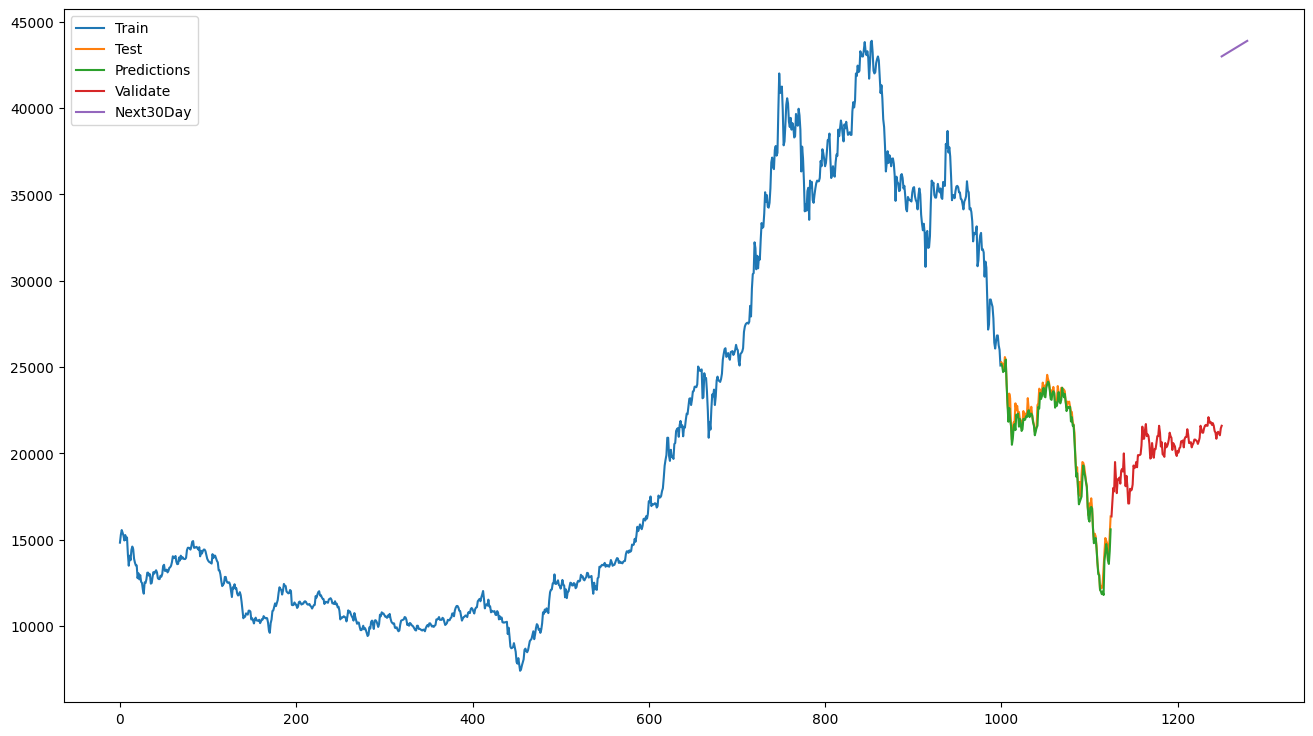

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()